In [1]:
# Data Processing
import pandas as pd
import numpy as np
import re
from numpy import mean, std

# Data visualization
!pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Creating the modeling dataset
from sklearn.datasets import make_classification

# Feature selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# Model and performance
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, 
                                     RandomizedSearchCV,
                                     cross_val_score, 
                                     KFold, 
                                     RepeatedKFold)
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import (confusion_matrix,
                             accuracy_score,
                             ConfusionMatrixDisplay,
                             matthews_corrcoef)
from sklearn.metrics import classification_report
from datetime import datetime
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Over sampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

# Treating data imbalance
!pip install -U imbalanced-learn

# checking memory space usage
import tracemalloc

# normality check
import math
from scipy.stats import shapiro #shapiro-wilk test

# variance check
import scipy.stats as stats
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings("ignore")

## Loading and prepraing dataset

In [2]:
# Loading dataset
df1 = pd.read_csv('adult_data.csv', header = None, na_values =' ?') # Passing ' ?' as na_values
df2 = pd.read_csv('adult_test.csv', header = None, na_values =' ?') # Passing ' ?' as na_values
df = pd.concat([df1, df2], ignore_index = True)
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
                'occupation', 'relationship','race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week',
                'country', 'income']
df.columns = column_names

# Changing the target variable class from categorical to numerical
df_mod = df.copy()
df_mod['income'] = df_mod['income'].str.replace('<=50K.', '<=50K',regex=False)
df_mod['income'] = df_mod['income'].str.replace('>50K.', '>50K', regex=False)
income_map={' <=50K':0,' >50K':1}
df_mod['income']=df_mod['income'].map(income_map).astype(int)
df_mod.income.value_counts()

# Aggregating class levels of 'Education' category
df_mod['education'] = df_mod['education'].str.replace('11th','High-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('9th','High-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('7th-8th','Junior-High', regex = True)
df_mod['education'] = df_mod['education'].str.replace('5th-6th', 'Primary', regex = True)
df_mod['education'] = df_mod['education'].str.replace('10th','High-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('1st-4th','Primary', regex = True)
df_mod['education'] = df_mod['education'].str.replace('Preschool','Pre-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('12th','High-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('Bachelors','Bachelors', regex = True)
df_mod['education'] = df_mod['education'].str.replace('HS-grad','HS-grad', regex = True)
df_mod['education'] = df_mod['education'].replace(['Masters', 'Prof-school'],'Masters', regex = True)
df_mod['education'] = df_mod['education'].replace(['Some-college','Assoc-acdm', 'Assoc-voc'],'College', regex = True)
df_mod['education'] = df_mod['education'].str.replace('Doctorate','Doctorate', regex = True)
df_mod['education'].unique()

# Dropping Duplicates
df_mod = df_mod.drop_duplicates()

# Removing missing values
x = df_mod.copy()
df_m1 = x.dropna()

# Data Encoding
df_m1_num = df_m1.drop(['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'country'], axis=1)
df_encoded1 = pd.get_dummies(df_m1[['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'country']],)
df_encoded1 = pd.concat([df_encoded1, df_m1_num], axis=1)
df_encoded1

# Train-test split for df_encoded1 dataset
X = df_encoded1.drop('income', axis=1) # all independent variables execpt the target 'income'
y = df_encoded1['income'] # Target variable
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3)
print("The number of records in the training set is", X_train1.shape[0])
print("The number of records in the test set is", X_test1.shape[0])

The number of records in the training set is 31622
The number of records in the test set is 13553


## Logistic Regression: Baseline model

Train accuracy 0.7930238441591297
Test accuracy 0.787722275510957
              precision    recall  f1-score   support

           0       0.80      0.96      0.87     10131
           1       0.72      0.26      0.39      3422

    accuracy                           0.79     13553
   macro avg       0.76      0.61      0.63     13553
weighted avg       0.78      0.79      0.75     13553



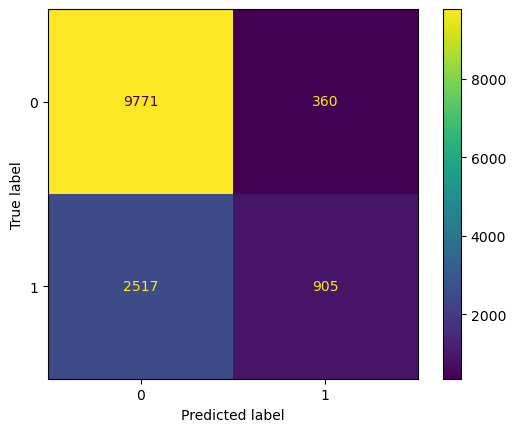

MCC score 0.34188841394936065


In [4]:
# Logistic regression on df_encoded1 data

# datatset
df = df_encoded1.copy()

# Train-test split (input required in X and y)
X = df.drop('income', axis=1) # all independent variables execpt the target 'income'
y = df['income'] # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# model building (input required in cf)
cf = LogisticRegression()

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

# MCC score
print ('MCC score', matthews_corrcoef(y_test, y_pred))

## Logistic regression after class imbalance treatment

### Random Oversampling

Train accuracy 0.6147105906142051
Test accuracy 0.6539511547258909
              precision    recall  f1-score   support

           0       0.82      0.69      0.75     10235
           1       0.36      0.53      0.43      3318

    accuracy                           0.65     13553
   macro avg       0.59      0.61      0.59     13553
weighted avg       0.71      0.65      0.67     13553



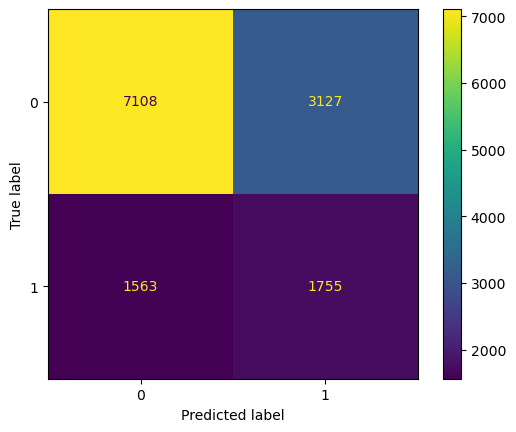

MCC score 0.2001044383639137


In [5]:
# datatset
df = df_encoded1.copy()

# Train-test split (input required in X and y)
X = df.drop('income', axis=1) # all independent variables execpt the target 'income'
y = df['income'] # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Technique: Random Oversampling
class_tech = RandomOverSampler()
X_train, y_train = class_tech.fit_resample(X_train, y_train)

# model building (input required in cf)
cf = LogisticRegression()

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

# MCC score
print ('MCC score', matthews_corrcoef(y_test, y_pred))

### SMOTE oversampling

Train accuracy 0.6117086081586355
Test accuracy 0.6592636316682653
              precision    recall  f1-score   support

           0       0.82      0.71      0.76     10170
           1       0.37      0.52      0.43      3383

    accuracy                           0.66     13553
   macro avg       0.59      0.61      0.59     13553
weighted avg       0.70      0.66      0.68     13553



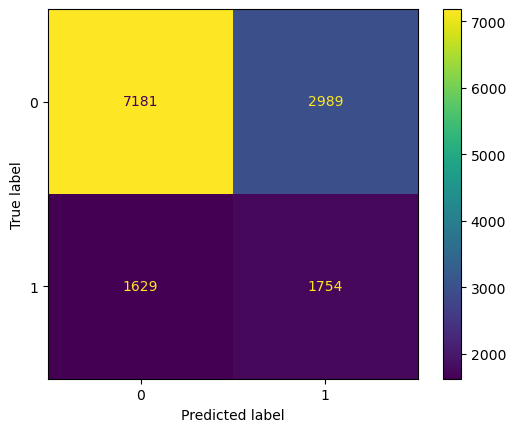

MCC score 0.20377495349903604


In [6]:
# datatset
df = df_encoded1.copy()

# Train-test split (input required in X and y)
X = df.drop('income', axis=1) # all independent variables execpt the target 'income'
y = df['income'] # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Technique: Random Oversampling
class_tech = SMOTE()
X_train, y_train = class_tech.fit_resample(X_train, y_train)

# model building (input required in cf)
cf = LogisticRegression()

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

# MCC score
print ('MCC score', matthews_corrcoef(y_test, y_pred))

### Random Undersampling

Train accuracy 0.6205669251302911
Test accuracy 0.7771711060281856
              precision    recall  f1-score   support

           0       0.81      0.93      0.86     10218
           1       0.59      0.31      0.41      3335

    accuracy                           0.78     13553
   macro avg       0.70      0.62      0.64     13553
weighted avg       0.75      0.78      0.75     13553



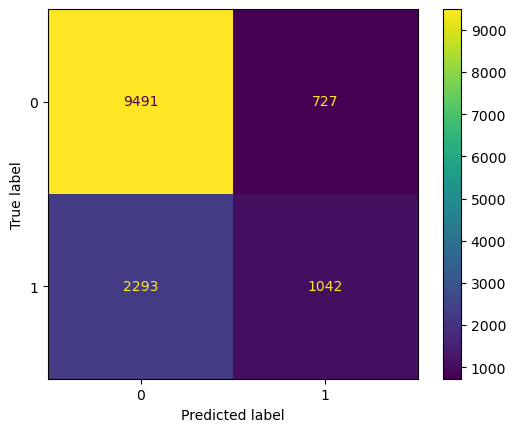

MCC score 0.30850953645728396


In [7]:
# datatset
df = df_encoded1.copy()

# Train-test split (input required in X and y)
X = df.drop('income', axis=1) # all independent variables execpt the target 'income'
y = df['income'] # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Technique: Random Oversampling
class_tech = RandomUnderSampler()
X_train, y_train = class_tech.fit_resample(X_train, y_train)

# model building (input required in cf)
cf = LogisticRegression()

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

# MCC score
print ('MCC score', matthews_corrcoef(y_test, y_pred))

### NearMiss undersampling

Train accuracy 0.5853799665680853
Test accuracy 0.6223714306795544
              precision    recall  f1-score   support

           0       0.82      0.64      0.72     10128
           1       0.35      0.58      0.44      3425

    accuracy                           0.62     13553
   macro avg       0.59      0.61      0.58     13553
weighted avg       0.70      0.62      0.65     13553



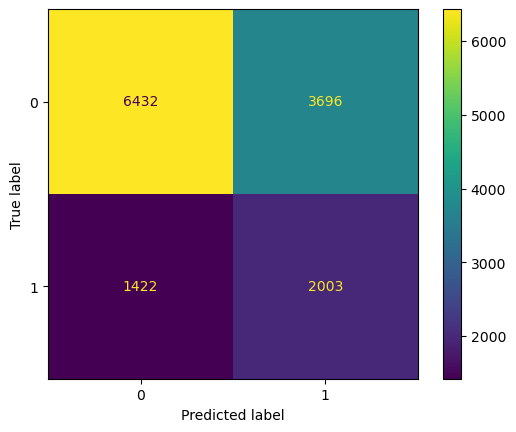

MCC score 0.19357536546563733


In [8]:
# datatset
df = df_encoded1.copy()

# Train-test split (input required in X and y)
X = df.drop('income', axis=1) # all independent variables execpt the target 'income'
y = df['income'] # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Technique: Random Oversampling
class_tech = NearMiss(version=3)
X_train, y_train = class_tech.fit_resample(X_train, y_train)

# model building (input required in cf)
cf = LogisticRegression()

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

# MCC score
print ('MCC score', matthews_corrcoef(y_test, y_pred))

## Cross-validation

### Memory Usage tracker setup

In [9]:
# memory space usage tracking
# import tracemalloc 
def app():
    lt = []
    for i in range(0, 100000):
        lt.append(i)

### Timer setup

In [10]:
# Creating a timer to check time-lapse
# from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

### K-Fold Cross Validation

In [13]:
# from sklearn.model_selection import cross_val_score
# K-Fold Cross validation on base dataset

cf = LogisticRegression()

# datatset
df = df_encoded1.copy()

# Train-test split (input required in X and y)
X = df.drop('income', axis=1) # all independent variables execpt the target 'income'
y = df['income'] # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# starting timer
start_time = timer(None)

# starting the memory monitoring
tracemalloc.start()

# function call
app()

# running cross-val
kfold_score = [cross_val_score (cf, X_train, y_train, scoring='accuracy', cv=10)]

# time stopper
timer(start_time)

# displaying the memory (current, peak)
print('memory usage: Current, Peak', tracemalloc.get_traced_memory())
 
# stopping the memorylibrary
tracemalloc.stop()

print(kfold_score)
print(np.average(kfold_score))


 Time taken: 0 hours 0 minutes and 2.58 seconds.
memory usage: Current, Peak (157884871, 185310271)
[array([0.79323427, 0.78469807, 0.79664769, 0.79380139, 0.78747628,
       0.7887413 , 0.78842505, 0.7830487 , 0.79696395, 0.79032258])]
0.7903359287684151


### Repeated K-Fold Cross Validation

In [15]:
# Repeated K-Fold on base dataset

cv1 = RepeatedKFold(n_splits=10, n_repeats=5)
cf = LogisticRegression()

# datatset
df = df_encoded1.copy()

# Train-test split (input required in X and y)
X = df.drop('income', axis=1) # all independent variables execpt the target 'income'
y = df['income'] # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# starting timer
start_time = timer(None)

# starting the memory monitoring
tracemalloc.start()

# function call
app()
 
# running cross-val
repeatK_scores = cross_val_score(cf, X_train, y_train, scoring='accuracy', cv=cv1)

# time stopper
timer(start_time)

# displaying the memory (current, peak)
print('memory usage: Current, Peak', tracemalloc.get_traced_memory())
 
# stopping the memorylibrary
tracemalloc.stop()

print (repeatK_scores)
print('Accuracy: %.3f (%.3f)' % (mean(repeatK_scores), std(repeatK_scores)))


 Time taken: 0 hours 0 minutes and 13.72 seconds.
memory usage: Current, Peak (203038477, 275736817)
[0.79892507 0.786595   0.78684377 0.79222011 0.79759646 0.80044276
 0.79190386 0.79063884 0.77830487 0.79822897 0.78785963 0.80493203
 0.79222011 0.78526249 0.79095509 0.7887413  0.79633144 0.78779254
 0.79380139 0.79032258 0.79924123 0.79038887 0.78684377 0.79886148
 0.79316888 0.78716003 0.79475016 0.78779254 0.78431373 0.79348514
 0.78406576 0.78469807 0.80139152 0.79633144 0.78494624 0.7944339
 0.79095509 0.80487034 0.78652751 0.78747628 0.78311729 0.80809358
 0.7972802  0.77830487 0.79127135 0.78747628 0.80360531 0.7972802
 0.79633144 0.78462998]
Accuracy: 0.792 (0.007)


### Checking the distribution of the repeated K-Fold scores

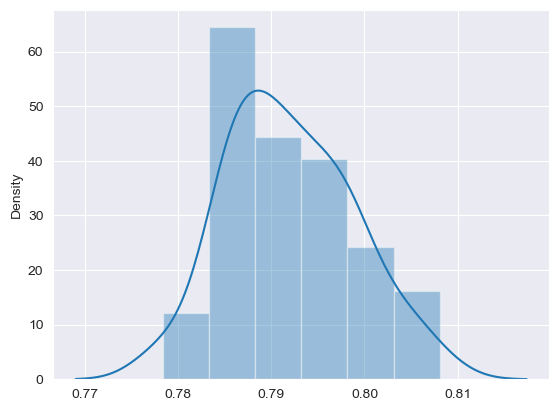

In [16]:
sns.set_style('darkgrid')
sns.distplot(repeatK_scores);

### Normality check through Shapiro-Wilk Test

In [17]:
# normality check for the repeatK_scores

shapiro(repeatK_scores)

ShapiroResult(statistic=0.9789714217185974, pvalue=0.5094432234764099)

From the output, we can see that p-value is greater than 0.05 which means that we have sufficient evidence to accept the null hypothesis which is the data is normally distributed

## Variance check

In [18]:
df = pd.read_csv('Repeated K-Fold Cross Validation Scores.csv')
df.head()

,RF,XGB
0,0.853936,0.875435
1,0.854885,0.872905
2,0.841240,0.852941
3,0.853574,0.871284
4,0.860848,0.866856


In [19]:
score = repeatK_scores.T
score

array([0.79892507, 0.786595  , 0.78684377, 0.79222011, 0.79759646,
       0.80044276, 0.79190386, 0.79063884, 0.77830487, 0.79822897,
       0.78785963, 0.80493203, 0.79222011, 0.78526249, 0.79095509,
       0.7887413 , 0.79633144, 0.78779254, 0.79380139, 0.79032258,
       0.79924123, 0.79038887, 0.78684377, 0.79886148, 0.79316888,
       0.78716003, 0.79475016, 0.78779254, 0.78431373, 0.79348514,
       0.78406576, 0.78469807, 0.80139152, 0.79633144, 0.78494624,
       0.7944339 , 0.79095509, 0.80487034, 0.78652751, 0.78747628,
       0.78311729, 0.80809358, 0.7972802 , 0.77830487, 0.79127135,
       0.78747628, 0.80360531, 0.7972802 , 0.79633144, 0.78462998])

In [20]:
df['LR'] = score

df.to_csv('Repeated K-Fold Cross Validation Scores.csv', index=False)
df.head()

,RF,XGB,LR
0,0.853936,0.875435,0.798925
1,0.854885,0.872905,0.786595
2,0.841240,0.852941,0.786844
3,0.853574,0.871284,0.792220
4,0.860848,0.866856,0.797596


In [21]:
# import scipy.stats as stats

fvalue, pvalue = stats.f_oneway(df['RF'], df['XGB'], df['LR'])
print(fvalue, pvalue)
# 1726.7368375233455 9.658683001406724e-71

# getting ANOVA table


2094.6237704060322 9.3312583232739e-109


In [22]:
# from scipy.stats import f_oneway

f_oneway(df['RF'], df['XGB'], df['LR'])

F_onewayResult(statistic=2094.6237704060322, pvalue=9.3312583232739e-109)

#### p-value is less than 0.05 hence we would reject the null hypothesis. This implies that we have sufficient proof to say that there is a difference in performance among the 3 models.

In [23]:
fvalue, pvalue = stats.f_oneway(df['RF'], df['XGB'])
print(fvalue, pvalue)

245.32134803200714 1.982538596022238e-28


p-value is less than 0.05 which means RF and XGB has different performance

In [24]:
fvalue, pvalue = stats.f_oneway(df['RF'], df['LR'])
print(fvalue, pvalue)

2075.7696886719423 9.154746793001955e-68


In [25]:
fvalue, pvalue = stats.f_oneway(df['XGB'], df['LR'])
print(fvalue, pvalue)

3736.468825426666 7.572679838274159e-80
